In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences = sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words = word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] + 1
                else:
                    vocab[word] = 1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [3]:
df = pd.read_csv("mtsamples.csv")

print(df.columns)
df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [4]:
df = df[df['transcription'].notna()]
sent_count,word_count = get_sentence_word_count(df['transcription'].tolist())
print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))



data_categories  = df.groupby(df['medical_specialty'])
i = 1
print('\t\tOriginal Categories')
print('No of categories: ', len(data_categories))
for cat_name, data_category in data_categories:
    print(cat_name + ' : ' + str(len(data_category)) )
    i += 1

Number of sentences in transcriptions column: 140214
Number of unique words in transcriptions column: 35805
		Original Categories
No of categories:  40
 Allergy / Immunology : 7
 Autopsy : 8
 Bariatrics : 18
 Cardiovascular / Pulmonary : 371
 Chiropractic : 14
 Consult - History and Phy. : 516
 Cosmetic / Plastic Surgery : 27
 Dentistry : 27
 Dermatology : 29
 Diets and Nutritions : 10
 Discharge Summary : 108
 ENT - Otolaryngology : 96
 Emergency Room Reports : 75
 Endocrinology : 19
 Gastroenterology : 224
 General Medicine : 259
 Hematology - Oncology : 90
 Hospice - Palliative Care : 6
 IME-QME-Work Comp etc. : 16
 Lab Medicine - Pathology : 8
 Letters : 23
 Nephrology : 81
 Neurology : 223
 Neurosurgery : 94
 Obstetrics / Gynecology : 155
 Office Notes : 50
 Ophthalmology : 83
 Orthopedic : 355
 Pain Management : 61
 Pediatrics - Neonatal : 70
 Physical Medicine - Rehab : 21
 Podiatry : 47
 Psychiatry / Psychology : 53
 Radiology : 273
 Rheumatology : 10
 SOAP / Chart / Progress N

In [6]:
filtered_data_categories = data_categories.filter(lambda x: x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
print('\t\tReduced Categories')
print('No of categories: ', len(data_categories))
for cat_name, data_category in data_categories:
    print(cat_name + ' : ' + str(len(data_category)) )

		Reduced Categories
No of categories:  40
 Allergy / Immunology : 7
 Autopsy : 8
 Bariatrics : 18
 Cardiovascular / Pulmonary : 371
 Chiropractic : 14
 Consult - History and Phy. : 516
 Cosmetic / Plastic Surgery : 27
 Dentistry : 27
 Dermatology : 29
 Diets and Nutritions : 10
 Discharge Summary : 108
 ENT - Otolaryngology : 96
 Emergency Room Reports : 75
 Endocrinology : 19
 Gastroenterology : 224
 General Medicine : 259
 Hematology - Oncology : 90
 Hospice - Palliative Care : 6
 IME-QME-Work Comp etc. : 16
 Lab Medicine - Pathology : 8
 Letters : 23
 Nephrology : 81
 Neurology : 223
 Neurosurgery : 94
 Obstetrics / Gynecology : 155
 Office Notes : 50
 Ophthalmology : 83
 Orthopedic : 355
 Pain Management : 61
 Pediatrics - Neonatal : 70
 Physical Medicine - Rehab : 21
 Podiatry : 47
 Psychiatry / Psychology : 53
 Radiology : 273
 Rheumatology : 10
 SOAP / Chart / Progress Notes : 166
 Sleep Medicine : 20
 Speech - Language : 9
 Surgery : 1088
 Urology : 156


In [7]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [8]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    #REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    #text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist = []
    lemmatizer = WordNetLemmatizer() 
    sentences = sent_tokenize(text)
    
    intial_sentences = sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist)

In [9]:
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [10]:
data.head()

,transcription,medical_specialty
3,d mmode mild mitral and tricuspid regurgit...,Cardiovascular / Pulmonary
4,there is a color doppler suggestive of a pat...,Cardiovascular / Pulmonary
7,d echocardiogram multiple view of the heart a...,Cardiovascular / Pulmonary
9,description normal lv systolic function,Cardiovascular / Pulmonary
11,d study moderate biatrial enlargement,Cardiovascular / Pulmonary


In [11]:
data.iloc[3]['transcription']

'description    normal lv systolic function '

In [12]:
vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english', ngram_range = (1, 3),
                             max_df = 0.75, use_idf = True, smooth_idf = True, max_features = 1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
feature_names[:5]

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal']

In [13]:
mask_list = ['Surgery', 'SOAP / Chart / Progress Notes', 'Office Notes', ' Consult - History and Phy.',
             'Emergency Room Reports', 'Discharge Summary', 'Pediatrics - Neonatal', 'Pain Management',
             'General Medicine', 'Neurosurgery']
filtered_data_categories['medical_specialty'] = filtered_data_categories['medical_specialty'].apply(lambda x: str.strip(x))
for i in mask_list:
    if i != 'Neurosurgery':
        mask = filtered_data_categories['medical_specialty'] == i
        filtered_data_categories = filtered_data_categories[~mask]
    else:
        mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
        filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
        
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])

In [14]:
'''
filtered_data_categories['medical_specialty'] = filtered_data_categories['medical_specialty'].apply(lambda x: str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'
'''


print('\t\tReduced Categories')
print('No of categories: ', len(data_categories))
for cat_name, data_category in data_categories:
    print(cat_name + ' : ' + str(len(data_category)) )
    
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

		Reduced Categories
No of categories:  40
 Allergy / Immunology : 7
 Autopsy : 8
 Bariatrics : 18
 Cardiovascular / Pulmonary : 371
 Chiropractic : 14
 Consult - History and Phy. : 516
 Cosmetic / Plastic Surgery : 27
 Dentistry : 27
 Dermatology : 29
 Diets and Nutritions : 10
 Discharge Summary : 108
 ENT - Otolaryngology : 96
 Emergency Room Reports : 75
 Endocrinology : 19
 Gastroenterology : 224
 General Medicine : 259
 Hematology - Oncology : 90
 Hospice - Palliative Care : 6
 IME-QME-Work Comp etc. : 16
 Lab Medicine - Pathology : 8
 Letters : 23
 Nephrology : 81
 Neurology : 223
 Neurosurgery : 94
 Obstetrics / Gynecology : 155
 Office Notes : 50
 Ophthalmology : 83
 Orthopedic : 355
 Pain Management : 61
 Pediatrics - Neonatal : 70
 Physical Medicine - Rehab : 21
 Podiatry : 47
 Psychiatry / Psychology : 53
 Radiology : 273
 Rheumatology : 10
 SOAP / Chart / Progress Notes : 166
 Sleep Medicine : 20
 Speech - Language : 9
 Surgery : 1088
 Urology : 156


(2770, 2)

In [15]:
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

In [16]:
def process_Text( text):
    wordlist = []
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)

In [17]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [18]:
vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english', ngram_range = (1, 3),
                             max_df = 0.75, min_df = 5, use_idf = True, smooth_idf = True, sublinear_tf = True,
                             max_features = 1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abdomen', 'abdomen abdomen', 'abdomen bowel', 'abdomen edema', 'abdomen pelvis', 'abdominal', 'abdominal cavity', 'abdominal patient', 'abdominal wall', 'ace', 'acetabulum', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenopathy', 'adenosine', 'adnexal', 'adrenal', 'adrenal gland', 'afebrile', 'ago', 'air', 'airway', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'alcohol use', 'allergies', 'allergies allergies', 'allergies medications', 'allergies social', 'allograft', 'alt', 'ancef', 'anemia', 'anesthesia', 'anesthesia endotracheal', 'anesthesia general', 'anesthesia patient', 'aneurysm', 'annular', 'anterior', 'anterior abdominal', 'anterior abdominal wall', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior cruciate ligament', 'anterior posterior', 'anteriorly', 'antrum', 'aorta', 'aortic', 'aortic valve', 'ap', 'ap lateral', 'apical', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery artery', 'artery carotid', 'artery carotid a

In [19]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components = 2, init = 'random', random_state = 0, perplexity = 40).fit_transform(tfIdfMatrix)

In [20]:
pca = PCA(n_components = 0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

In [21]:
smote_over_sample = SMOTE(sampling_strategy = 'minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,random_state = 1)   
print('Train_Set_Size:' + str(X_train.shape))
print('Test_Set_Size:' + str(X_test.shape))

Train_Set_Size:(2424, 619)
Test_Set_Size:(809, 619)


In [22]:
models = {'SVC': {'model': SVC()}, 'RandomForestClassifier': {'model': RandomForestClassifier()},
          'LogisticRegression': {'model': LogisticRegression()}}

In [23]:
for name, m in models.items():
    
    model = m['model']
    result = cross_validate(model, X_train, y_train, cv = 10)
    
    mean_val_accuracy = round(sum(result['test_score'])/len(result['test_score']), 4)
    
    m['val_accuracy'] = mean_val_accuracy

In [24]:
models_result = []

for name, v in models.items():
    lst = [name, v['val_accuracy']]
    models_result.append(lst)

df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy'])
df_results.sort_values(by = 'val_accuracy', ascending = False, inplace = True)
df_results.reset_index(inplace = True, drop = True)
df_results

,model,val_accuracy
0,LogisticRegression,0.6300
1,SVC,0.5767
2,RandomForestClassifier,0.5128


In [25]:
best_model = df_results.iloc[0]
model = models[best_model[0]]['model']
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
yhat = model.predict(X_test)

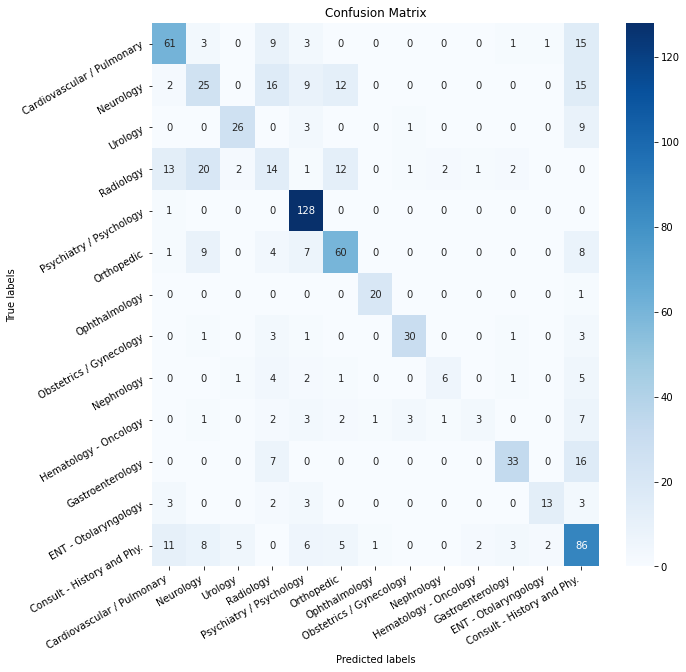

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.66      0.66      0.66        93
                 Neurology       0.37      0.32      0.34        79
                   Urology       0.76      0.67      0.71        39
                 Radiology       0.23      0.21      0.22        68
   Psychiatry / Psychology       0.77      0.99      0.87       129
                Orthopedic       0.65      0.67      0.66        89
             Ophthalmology       0.91      0.95      0.93        21
   Obstetrics / Gynecology       0.86      0.77      0.81        39
                Nephrology       0.67      0.30      0.41        20
     Hematology - Oncology       0.50      0.13      0.21        23
          Gastroenterology       0.80      0.59      0.68        56
      ENT - Otolaryngology       0.81      0.54      0.65        24
Consult - History and Phy.       0.51      0.67      0.58       129

                  accuracy                    

In [27]:
labels = category_list
cm = confusion_matrix(y_test, yhat, labels)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(cm, annot = True, cmap = "Blues", ax = ax, fmt = 'g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation = 30, horizontalalignment = 'right')
plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'right')     
plt.show()
print(classification_report(y_test, yhat, labels = category_list))